In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sns
import utils

plt.style.use("ggplot")

In [2]:
# Login with Oracle username and password
eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


# Get chemistry data

* Download chemistry data for the NIVA river monitoring stations (elveovervåkingsprogrammet):
    * Locations: Drammenselva, Numedalslågen and Glomma.
    * Get the data from NIVABasen (or similar internal NIVA system) initially. (Note: there is already chemistry data in this folder: aquainfra/data/river/water_chem/raw_vannmiljo, but it has data gaps for some reason. Lets delete this and start with NIVA data for now).
    * Parameters of potential interest: SPM, DOC, TOC, SiO2, TP, TN, NOx-N, NH4-N, SRP, TDP, FDOM or CDOM (if measured?). To discuss with Helene which of these we ultimately want to focus on in AquaInfra
    * Save raw data e.g. here: aquainfra/data/river/water_chem/raw_niva (need to make that last folder)
    * Future extension: download chemistry data from Vannmiljø using the Vannmiljø API
* Quick QC of the data.
* Clean data if necessary and standardise column naming
* Save as csvs in aquainfra/data/river/water_chem/cleaned (need to make that last folder)
* Also save water chemistry site metadata to csv (e.g. station name, station id, lat, lon, any other info we have)

## 1. Get stations

In [3]:
# Get all projects in nivadatabase
proj_df = nivapy.da.select_ndb_projects(eng)
proj_df.head()

1507 projects in the NIVADATABASE.


,project_id,project_name,project_description
0,1,xxx,None
1,55,PARCOM_Aquateam,None
2,56,PARCOM_NIVA,None
3,58,MAR_BOK,Fagdata
4,59,MAR_IMA,Fagdata


In [4]:
# Filter to just the project for "Elveovervåkingsprogrammet"
proj_df = proj_df.query(
    "project_name.str.contains('Elveovervåkingsprogrammet')", engine="python"
)
proj_df

,project_id,project_name,project_description
998,10306,Elveovervåkingsprogrammet,Etterfølgeren til RID. Overvåking av tilførsle...


In [5]:
stn_df = nivapy.da.select_ndb_stations(eng)
stn_df.head()

30168 stations in the NIVADATABASE.


,station_id,station_code,station_name,station_type,latitude,longitude
0,3561,BUSEDRA,Drammenselva,Elv,59.753992,10.009029
1,3562,FINEALT,Altaelva.,Elv,69.901142,23.287058
2,3563,NOREVEF,Vefsna.,Elv,65.749464,13.239104
3,3564,ROGEORR,Orreelva,Elv,58.731430,5.529362
4,3565,ROGESUL,Suldalslågen.,Elv,59.482215,6.259855


In [6]:
# Select stations for the specific project
stn_df = nivapy.da.select_ndb_project_stations(proj_df, eng, drop_dups=True)
stn_df.head()

,station_id,station_code,station_name,station_type,longitude,latitude
0,40352,BUSEDRA,Drammenselva,Elv,10.007898,59.752576
1,40353,SKI,Skienselva,Elv,9.608040,59.204106
2,40354,OTR2,Otra v/Skråstad,Elv,7.958165,58.184772
3,40355,NUM1,Numedalslågen v/E18,Elv,10.070949,59.101283
4,40356,CGL SAR,"Glomma, Sarpsfossen",Elv,11.134112,59.279802


In [7]:
# Show stations
nivapy.spatial.quickmap(
    stn_df, cluster=True, aerial_imagery=True, kartverket=True, popup="station_code"
)

In [8]:
# Select the stations of interest
stations_to_keep = ['Drammenselva', 'Numedalslågen v/E18', 'Glomma, Sarpsfossen']
sel_stn_df = stn_df[stn_df['station_name'].isin(stations_to_keep)]
sel_stn_df

,station_id,station_code,station_name,station_type,longitude,latitude
0,40352,BUSEDRA,Drammenselva,Elv,10.007898,59.752576
3,40355,NUM1,Numedalslågen v/E18,Elv,10.070949,59.101283
4,40356,CGL SAR,"Glomma, Sarpsfossen",Elv,11.134112,59.279802


In [9]:
# Show stations
nivapy.spatial.quickmap(
    sel_stn_df, cluster=True, aerial_imagery=True, kartverket=True, popup="station_code"
)

In [10]:
# Save metadata to csv 
sel_stn_df.to_csv('../../data/river/water_chem/raw_niva/dremmen_glomma_numed_metadata.csv', index = False)

## 2. Get parameters of interest 

In [11]:
# Find water chemsitry parameters available for a set of stations within a period of interest
st_dt = "1980-01-01"
end_dt = "2024-08-31"
par_df = nivapy.da.select_ndb_station_parameters(sel_stn_df, st_dt, end_dt, eng)
par_df.head()

/opt/conda/lib/python3.11/site-packages/nivapy3/da.py:440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stn_df["station_id"].drop_duplicates(inplace=True)


124 parameters available for the selected stations and dates.


,parameter_id,parameter_name,unit
0,3622,4-iso-nonylfenol,ng/L
1,3620,4-n-nonylfenol,ng/L
2,3467,4-tert-octylfenol,ng/L
3,14,ANC,µEkv/L
4,256,AOX,ug/l


In [ ]:
# par_df['parameter_name'].unique()

In [12]:
# Filter to parameters of interest
par_list = ['NH4-N', 'NO3+NO2-N', 'NO3-N', 'SiO2', 'TOC', 'TOTN', 'TOTP_P', 'DOC', 'STS', 'TSM', 'P-PO4', 'PO4-P', 'TOTP/F', 'UV-Abs. 410nm', 'Farge'] 
par_df = par_df.query("parameter_name in @par_list")
par_df

,parameter_id,parameter_name,unit
35,1539,DOC,mg/L C
36,570,DOC,mg/l
40,288,Farge,mg Pt/l
57,8,NH4-N,µg/l
58,1625,NO3+NO2-N,µg/l
59,7,NO3-N,µg/l
67,2027,P-PO4,µg/l P
76,12,PO4-P,µg/l
88,396,STS,mg/l
92,258,SiO2,mg/l


## 3. Get water chemistry 

In [13]:
wc_df, dup_df = nivapy.da.select_ndb_water_chemistry(
    sel_stn_df, par_df, st_dt, end_dt, eng, lod_flags=False, drop_dups=True
)
wc_df.head()

/opt/conda/lib/python3.11/site-packages/nivapy3/da.py:729: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stn_df["station_id"].drop_duplicates(inplace=True)
/opt/conda/lib/python3.11/site-packages/nivapy3/da.py:870: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["parameter_name"].fillna("", inplace=True)
/opt/conda/lib/python3.11/site-package

,station_id,station_code,station_name,sample_date,depth1,depth2,DOC_mg/L C,DOC_mg/l,Farge_mg Pt/l,NH4-N_µg/l,...,P-PO4_µg/l P,PO4-P_µg/l,STS_mg/l,SiO2_mg/l,TOC_mg/l,TOTN_µg/l,TOTP/F_µg/l P,TOTP_P_µg/l P,TSM_mg/l,UV-Abs. 410nm_Abs/cm
,,,,,,,,,,,,,,,,,,,,,
0,40352,DRA1,Drammenselva v/Krokstadelva,1990-01-11,0,0,NaN,NaN,NaN,NaN,...,NaN,0.5,NaN,NaN,NaN,350.0,NaN,NaN,0.8,NaN
1,40352,DRA1,Drammenselva v/Krokstadelva,1990-02-12,0,0,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,419.0,NaN,NaN,2.0,NaN
2,40352,DRA1,Drammenselva v/Krokstadelva,1990-03-13,0,0,NaN,NaN,NaN,NaN,...,NaN,1.5,NaN,NaN,NaN,405.0,NaN,NaN,1.4,NaN
3,40352,DRA1,Drammenselva v/Krokstadelva,1990-04-18,0,0,NaN,NaN,NaN,NaN,...,NaN,1.5,NaN,NaN,NaN,399.0,NaN,NaN,1.3,NaN
4,40352,DRA1,Drammenselva v/Krokstadelva,1990-05-21,0,0,NaN,NaN,NaN,NaN,...,NaN,0.5,NaN,NaN,NaN,317.0,NaN,NaN,1.7,NaN


In [14]:
# Save water chemistry to csv
wc_df.to_csv('../../data/river/water_chem/raw_niva/dremmen_glomma_numed_wc_2024.csv', index = False)

## 4. Quick data screening

In [12]:
# Check for negative values
variables = ['DOC_mg/L C', 'DOC_mg/l', 'Farge_mg Pt/l', 'NH4-N_µg/l',
             'NO3+NO2-N_µg/l', 'NO3-N_µg/l', 'P-PO4_µg/l P', 'PO4-P_µg/l',
             'STS_mg/l', 'SiO2_mg/l', 'TOC_mg/l', 'TOTN_µg/l', 'TOTP/F_µg/l P',
             'TOTP_P_µg/l P', 'TSM_mg/l', 'UV-Abs. 410nm_Abs/cm'] 

negative_values = wc_df[variables].lt(0).any()

# Print the result
print("Negative values in the dataframe for the specified variables:")
print(negative_values)


Negative values in the dataframe for the specified variables:
DOC_mg/L C              False
DOC_mg/l                False
Farge_mg Pt/l           False
NH4-N_µg/l              False
NO3+NO2-N_µg/l          False
NO3-N_µg/l              False
P-PO4_µg/l P            False
PO4-P_µg/l              False
STS_mg/l                False
SiO2_mg/l               False
TOC_mg/l                False
TOTN_µg/l               False
TOTP/F_µg/l P           False
TOTP_P_µg/l P           False
TSM_mg/l                False
UV-Abs. 410nm_Abs/cm    False
dtype: bool


In [13]:
# Check for missing data
def check_missing_data(df):
    missing_data = df.isnull().sum()
    print("\nMissing data count for each column:")
    print(missing_data)

check_missing_data(wc_df)


Missing data count for each column:
station_id                 0
station_code               0
station_name               0
sample_date                0
depth1                     0
depth2                     0
DOC_mg/L C              1220
DOC_mg/l                1622
Farge_mg Pt/l           1458
NH4-N_µg/l               171
NO3+NO2-N_µg/l          1611
NO3-N_µg/l                48
P-PO4_µg/l P            1596
PO4-P_µg/l                74
STS_mg/l                1457
SiO2_mg/l                543
TOC_mg/l                 247
TOTN_µg/l                237
TOTP/F_µg/l P           1460
TOTP_P_µg/l P           1468
TSM_mg/l                  42
UV-Abs. 410nm_Abs/cm    1314
dtype: int64


In [14]:
# Group by station_id and station_name
grouped = wc_df.groupby(['station_id', 'station_name'])

# Initialize a dictionary to store the results
results = {}

# Iterate over each group
for (station_id, station_name), group in grouped:
    results[(station_id, station_name)] = {}
    for variable in variables:
        # Drop NaN values for the variable
        non_na_group = group.dropna(subset=[variable])
        if not non_na_group.empty:
            start_year = non_na_group['sample_date'].dt.year.min()
            end_year = non_na_group['sample_date'].dt.year.max()
            results[(station_id, station_name)][variable] = (start_year, end_year)

# Print the results
for station, variables in results.items():
    print(f"Station: {station}")
    for variable, (start_year, end_year) in variables.items():
        print(f"  {variable}: Start Year = {start_year}, End Year = {end_year}")

Station: (40352, 'Drammenselva v/Krokstadelva')
  DOC_mg/L C: Start Year = 1992, End Year = 2024
  DOC_mg/l: Start Year = 2020, End Year = 2020
  Farge_mg Pt/l: Start Year = 2021, End Year = 2024
  NH4-N_µg/l: Start Year = 1992, End Year = 2024
  NO3+NO2-N_µg/l: Start Year = 2023, End Year = 2023
  NO3-N_µg/l: Start Year = 1990, End Year = 2024
  P-PO4_µg/l P: Start Year = 2015, End Year = 2015
  PO4-P_µg/l: Start Year = 1990, End Year = 2024
  STS_mg/l: Start Year = 2021, End Year = 2024
  SiO2_mg/l: Start Year = 1995, End Year = 2024
  TOC_mg/l: Start Year = 1991, End Year = 2024
  TOTN_µg/l: Start Year = 1990, End Year = 2024
  TOTP/F_µg/l P: Start Year = 2017, End Year = 2020
  TOTP_P_µg/l P: Start Year = 2021, End Year = 2024
  TSM_mg/l: Start Year = 1990, End Year = 2024
  UV-Abs. 410nm_Abs/cm: Start Year = 2017, End Year = 2023
Station: (40355, 'Numedalslågen v/E18')
  DOC_mg/L C: Start Year = 1992, End Year = 2024
  DOC_mg/l: Start Year = 2020, End Year = 2020
  Farge_mg Pt/l: 

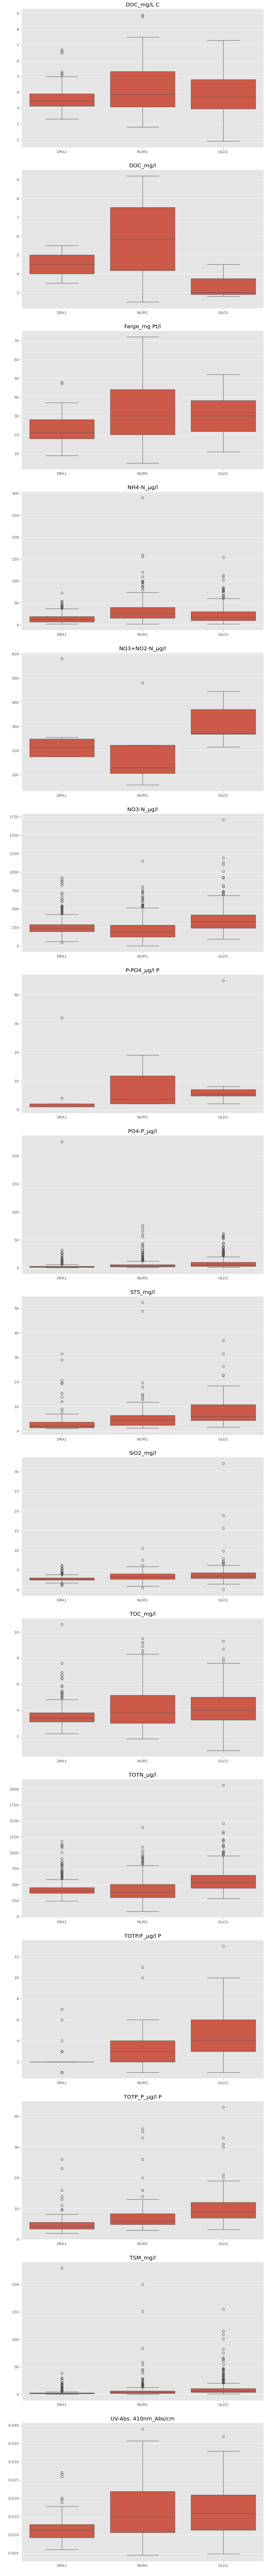

In [15]:
# Raw data distribution
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date'])

# Create a single figure with boxplots for each variable
fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(10, len(variables) * 6))

for i, var in enumerate(variables):
    sns.boxplot(x='station_code', y=var, data=wc_df, ax=axes[i])
    axes[i].set_title(f'{var}')
    axes[i].set_xlabel(' ')
    axes[i].set_ylabel(' ')

plt.tight_layout()
plt.show()

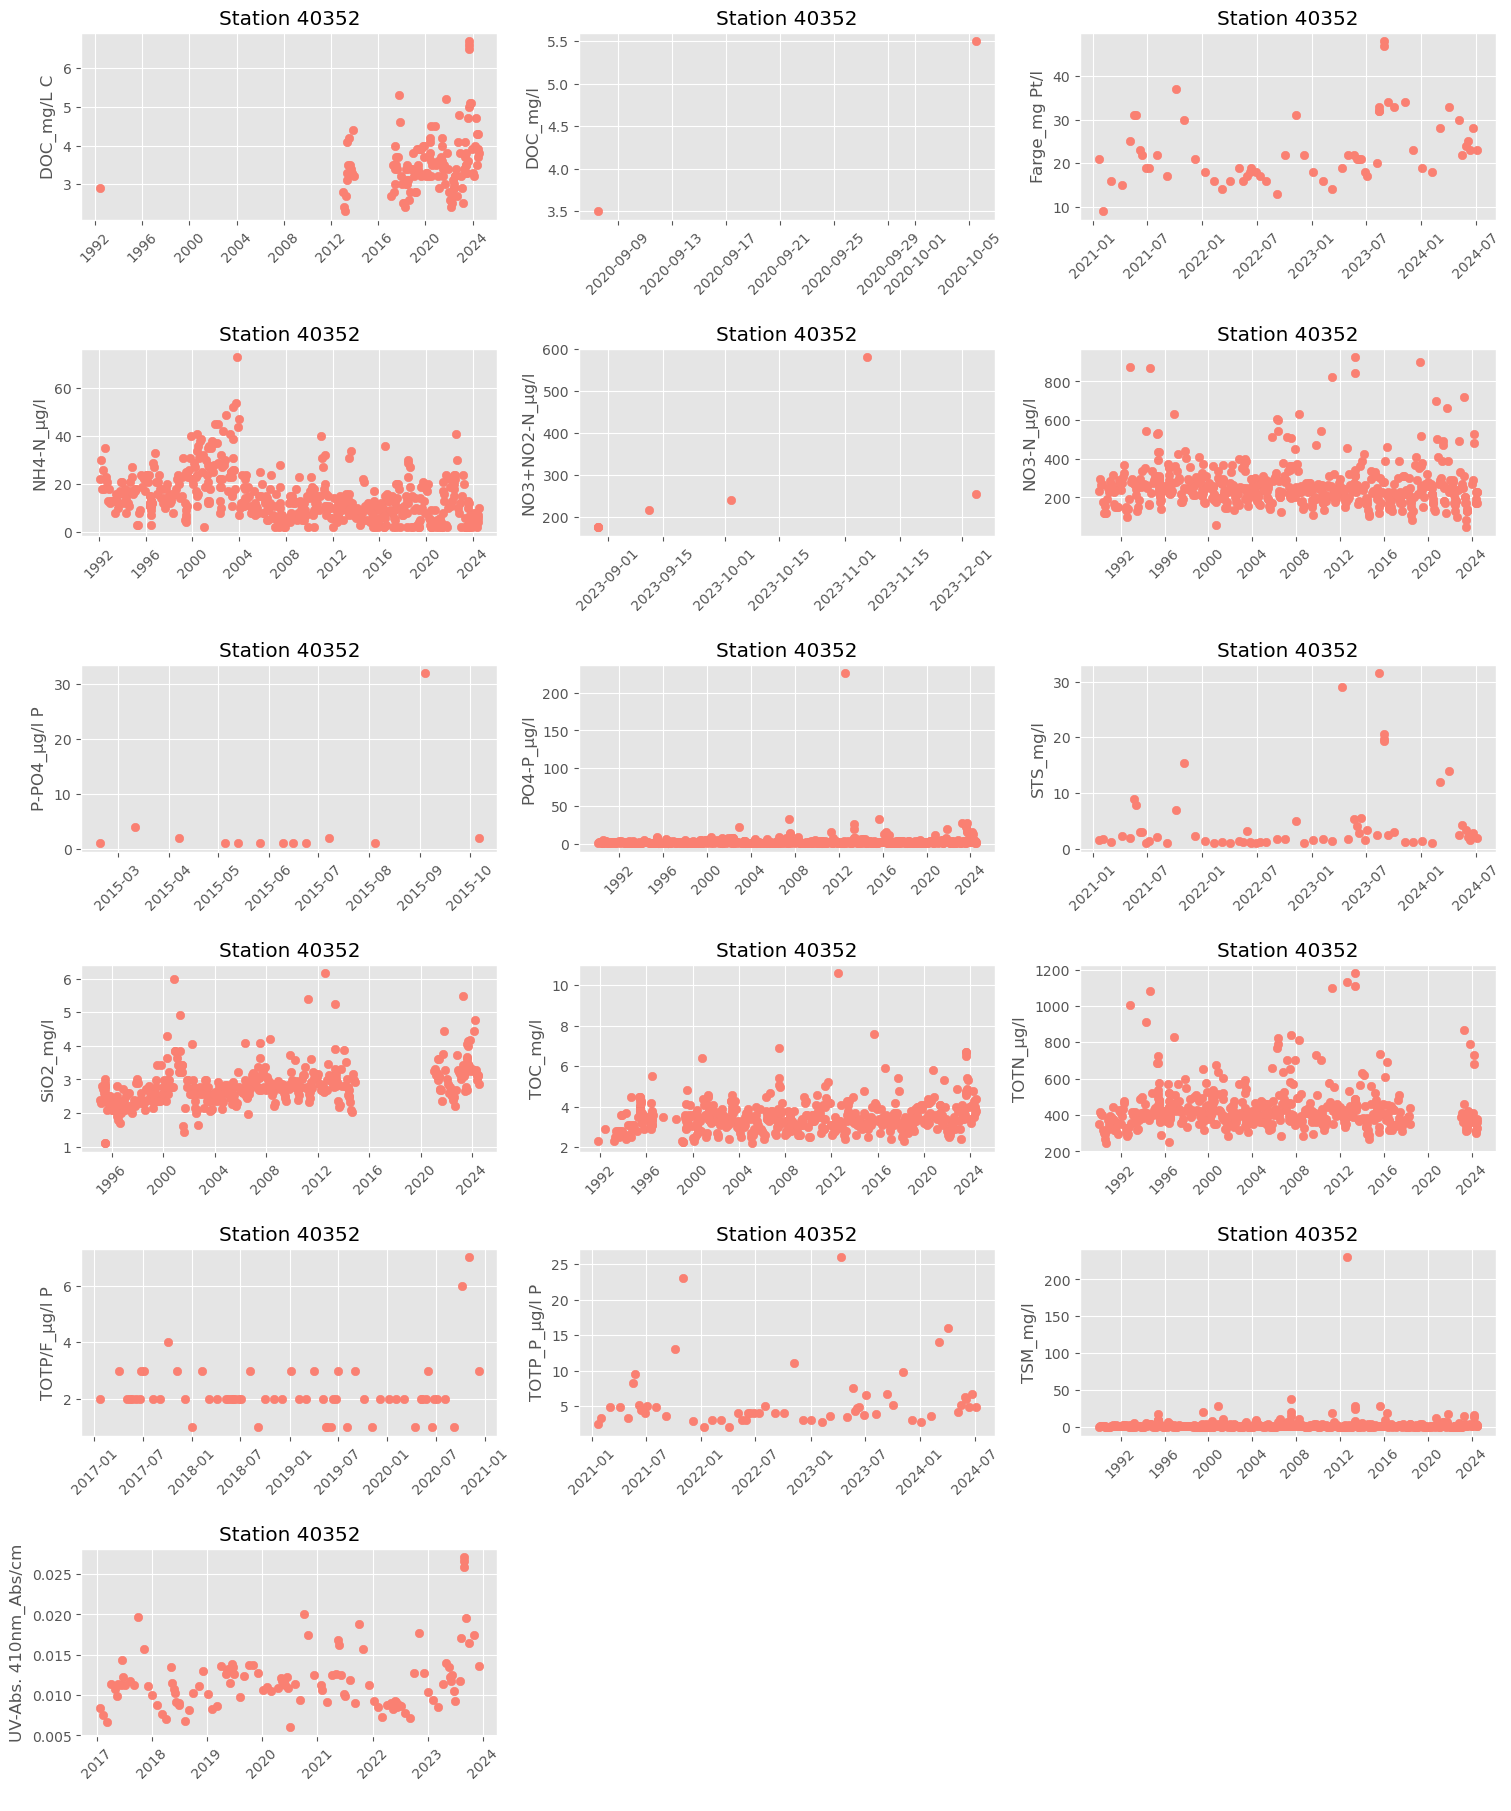

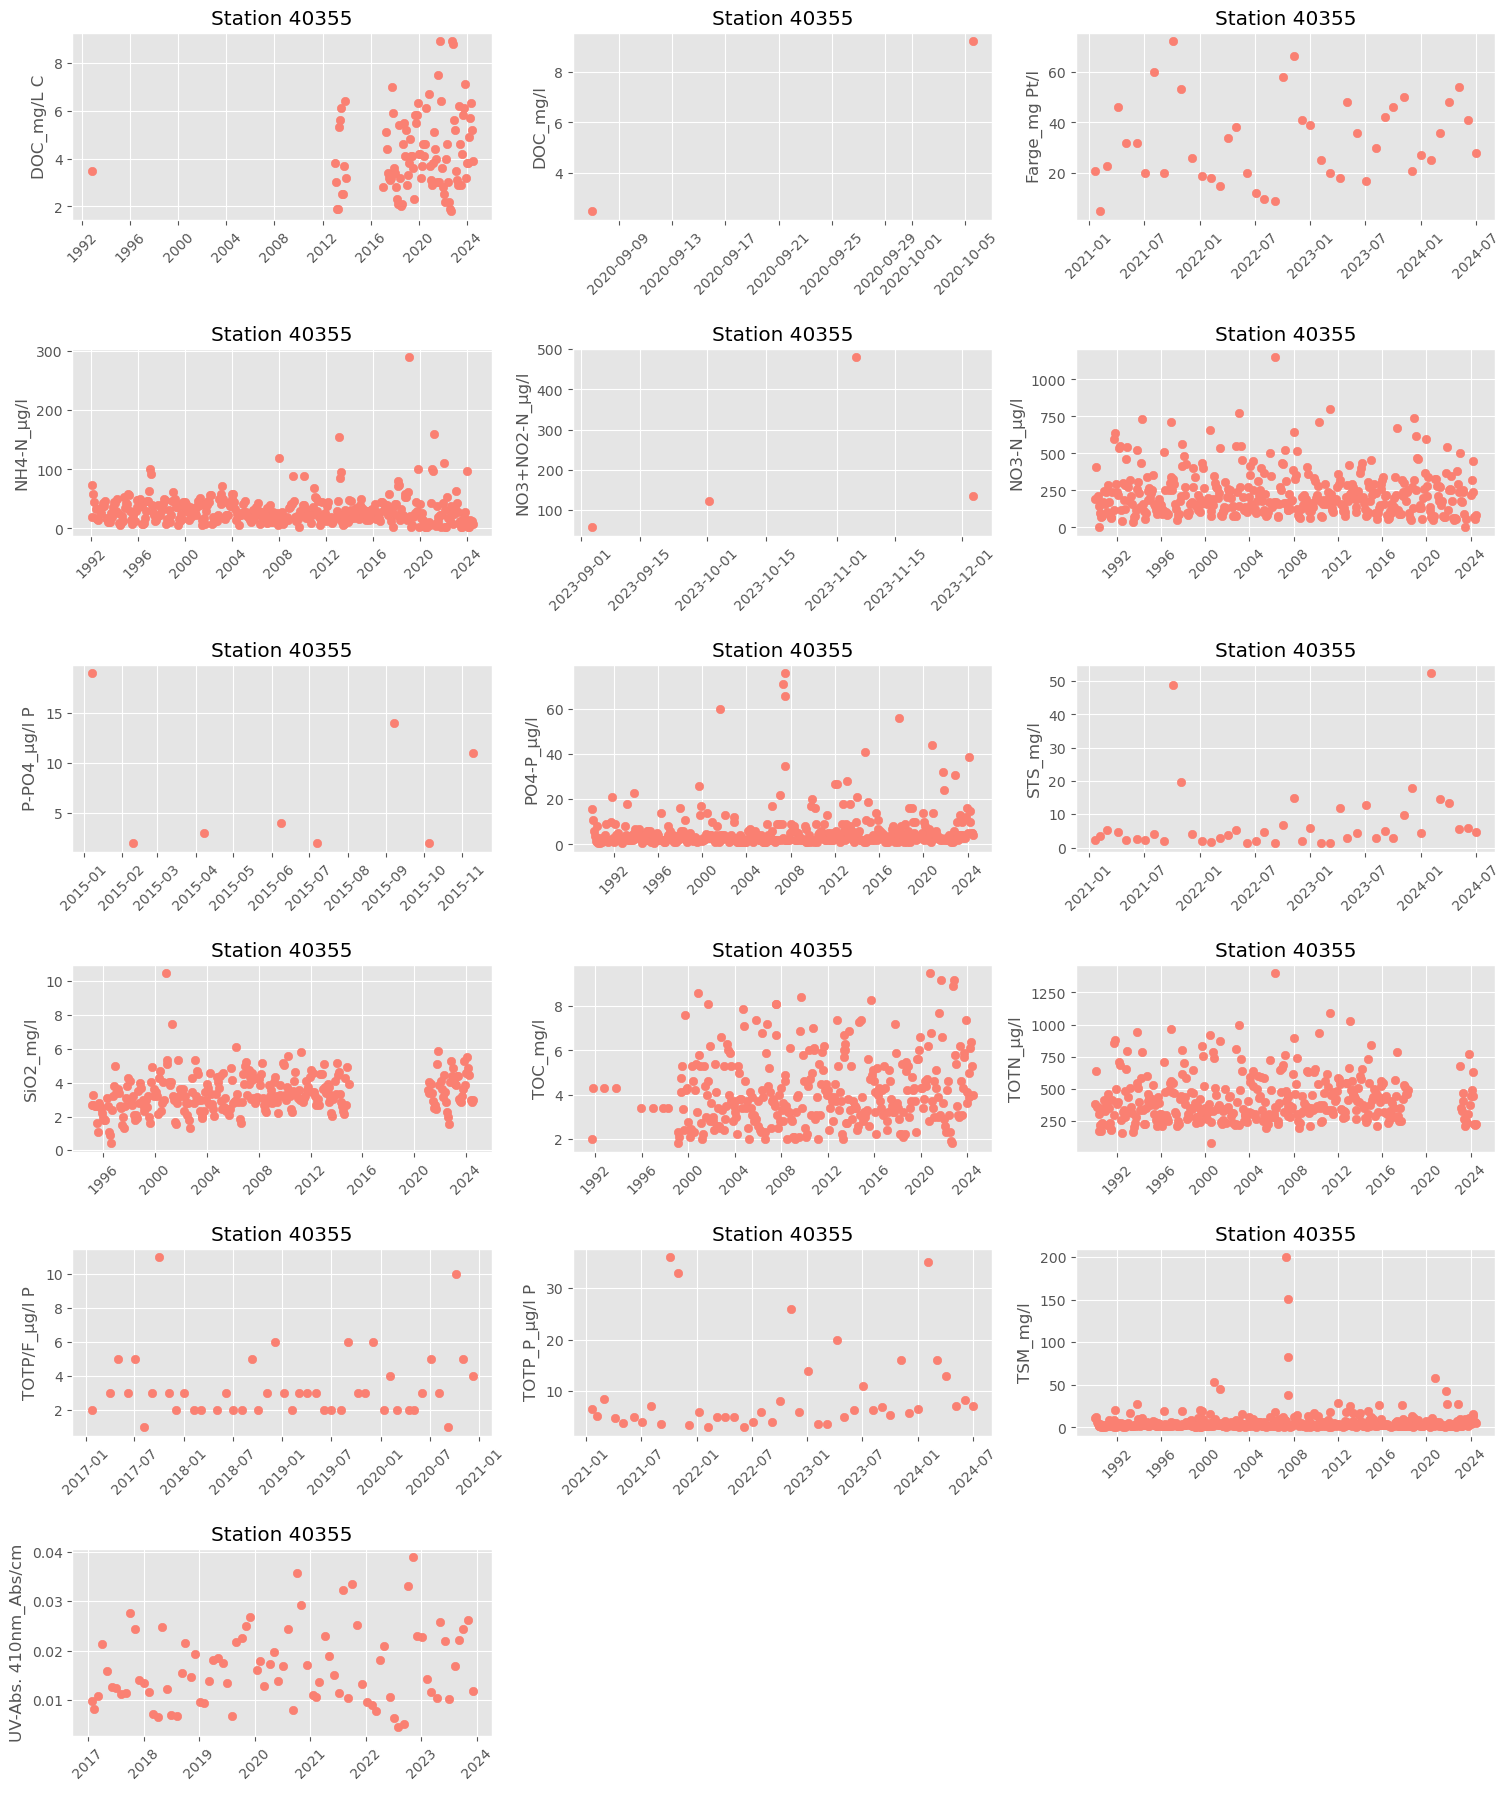

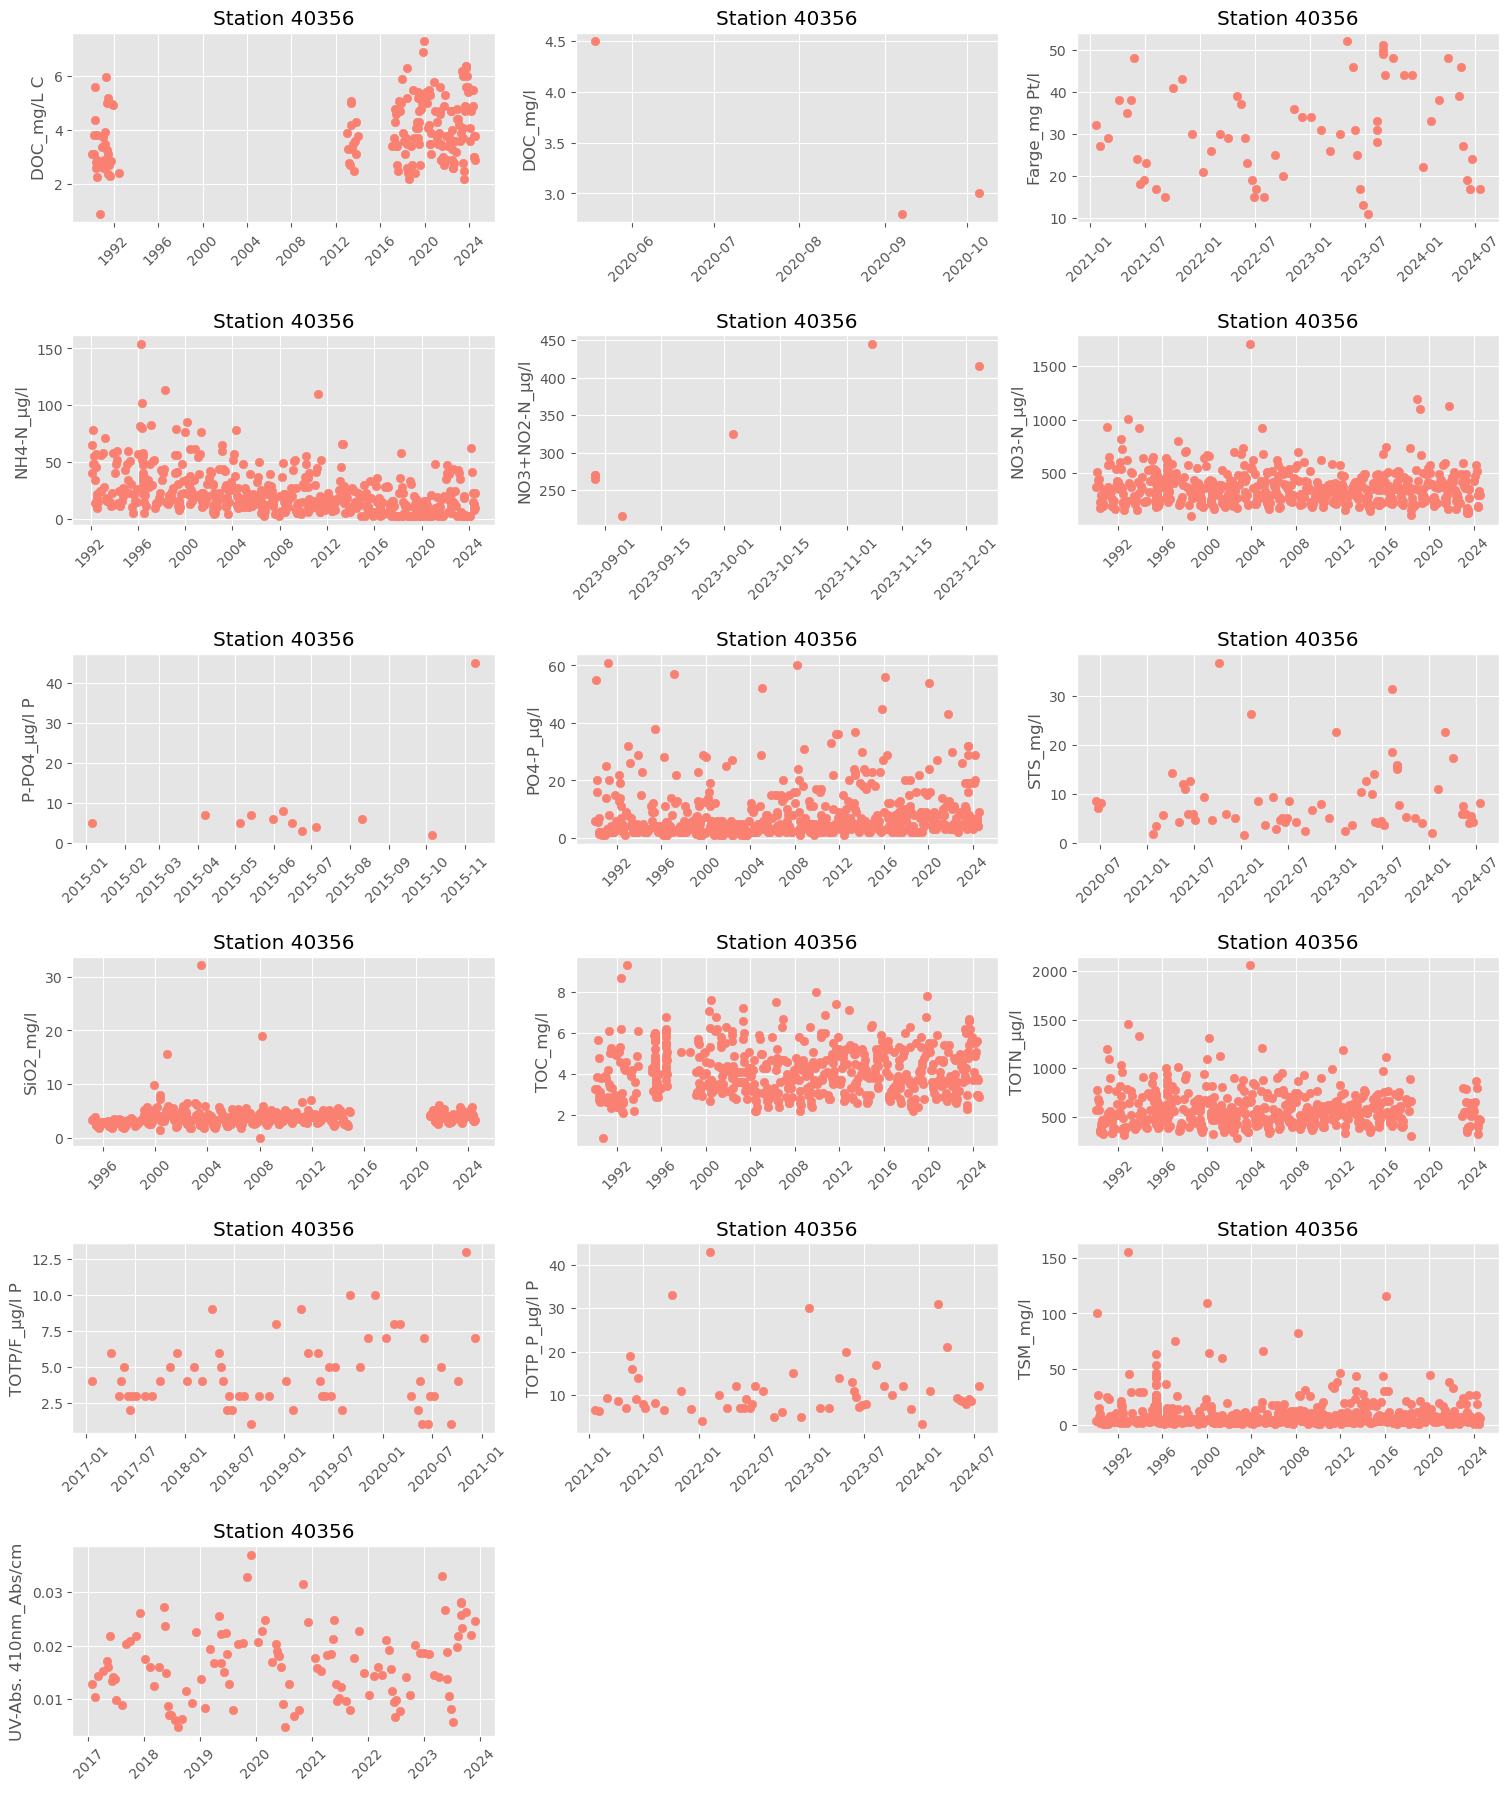

In [16]:
# Get unique station IDs
stations = wc_df["station_id"].unique()

# Number of columns for subplots
num_cols = 3

# Plot each variable for each station separately
for station in stations:
    station_df = wc_df[wc_df["station_id"] == station]
    
    # Get list of variables to plot (excluding non-numeric and metadata columns)
    variables = station_df.columns.difference(["station_id", "station_code", "station_name", "sample_date", "depth1", "depth2"])
    
    # Number of rows needed for subplots
    num_rows = (len(variables) + num_cols - 1) // num_cols
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), constrained_layout=True)
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
    
    # Plot each variable
    for i, var in enumerate(variables):
        ax = axes[i]
        ax.scatter(station_df["sample_date"], station_df[var], marker='o', color='salmon')
        ax.set_title(f"Station {station}")
        ax.set_xlabel(" ")
        ax.set_ylabel(var)
        ax.tick_params(axis='x', rotation=45)
       
    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Show plot
    plt.show()

In [19]:
# Combine PO4-P and P-PO4 columns

# Fill NaN values with 0
wc_df['P-PO4_µg/l P'] = wc_df['P-PO4_µg/l P'].fillna(0)
wc_df['PO4-P_µg/l'] = wc_df['PO4-P_µg/l'].fillna(0)

# Combine columns
wc_df['PO4-P_µg/l'] = wc_df['P-PO4_µg/l P'] + wc_df['PO4-P_µg/l']

# Drop the original 'P-PO4_µg/l P' column
wc_df = wc_df.drop(columns=['P-PO4_µg/l P'])
wc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629 entries, 0 to 1628
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   station_id            1629 non-null   int64         
 1   station_code          1629 non-null   object        
 2   station_name          1629 non-null   object        
 3   sample_date           1629 non-null   datetime64[ns]
 4   depth1                1629 non-null   int64         
 5   depth2                1629 non-null   int64         
 6   DOC_mg/L C            409 non-null    float64       
 7   DOC_mg/l              7 non-null      float64       
 8   Farge_mg Pt/l         171 non-null    float64       
 9   NH4-N_µg/l            1458 non-null   float64       
 10  NO3+NO2-N_µg/l        18 non-null     float64       
 11  NO3-N_µg/l            1581 non-null   float64       
 12  PO4-P_µg/l            1629 non-null   float64       
 13  STS_mg/l          

## 5. Flag outliers

In [20]:
# Drop variables with very few data and depths
wc_df = wc_df.drop(columns=['DOC_mg/l', 'NO3+NO2-N_µg/l', 'depth1', 'depth2'])
wc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629 entries, 0 to 1628
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   station_id            1629 non-null   int64         
 1   station_code          1629 non-null   object        
 2   station_name          1629 non-null   object        
 3   sample_date           1629 non-null   datetime64[ns]
 4   DOC_mg/L C            409 non-null    float64       
 5   Farge_mg Pt/l         171 non-null    float64       
 6   NH4-N_µg/l            1458 non-null   float64       
 7   NO3-N_µg/l            1581 non-null   float64       
 8   PO4-P_µg/l            1629 non-null   float64       
 9   STS_mg/l              172 non-null    float64       
 10  SiO2_mg/l             1086 non-null   float64       
 11  TOC_mg/l              1382 non-null   float64       
 12  TOTN_µg/l             1392 non-null   float64       
 13  TOTP/F_µg/l P     

Filter the outliers using the MAD function with a very high threshold to identify only the extremes.

In [22]:
# Filter outliers 
id_cols = ["station_id", "station_code", "station_name", "sample_date"]
pars = ['DOC_mg/L C', 'Farge_mg Pt/l', 'NH4-N_µg/l', 'NO3-N_µg/l',
       'PO4-P_µg/l', 'STS_mg/l', 'SiO2_mg/l', 'TOC_mg/l',
       'TOTN_µg/l', 'TOTP/F_µg/l P', 'TOTP_P_µg/l P', 'TSM_mg/l',
       'UV-Abs. 410nm_Abs/cm'] 

df = wc_df[id_cols + pars].copy()
df = df.melt(id_vars=id_cols, var_name="parameter").dropna()

# Test each series for outliers
df_list = []
stn_list = df["station_id"].unique().tolist()

for stn_id in stn_list:
    for par in pars:
        stn_par_df = df.query("(station_id == @stn_id) and (parameter == @par)").copy()
        if len(stn_par_df) > 0:
            stn_par_df["outlier"] = utils.double_mad_from_median(
                stn_par_df["value"], thresh=10
            )
            df_list.append(stn_par_df)
df = pd.concat(df_list)
df.head()

,station_id,station_code,station_name,sample_date,parameter,value,outlier
29,40352,DRA1,Drammenselva v/Krokstadelva,1992-06-11 00:00:00,DOC_mg/L C,2.9,False
383,40352,DRA1,Drammenselva v/Krokstadelva,2013-01-08 13:45:00,DOC_mg/L C,2.8,False
384,40352,DRA1,Drammenselva v/Krokstadelva,2013-02-05 00:00:00,DOC_mg/L C,2.4,False
386,40352,DRA1,Drammenselva v/Krokstadelva,2013-03-05 11:00:00,DOC_mg/L C,2.3,False
387,40352,DRA1,Drammenselva v/Krokstadelva,2013-04-04 00:00:00,DOC_mg/L C,2.7,False


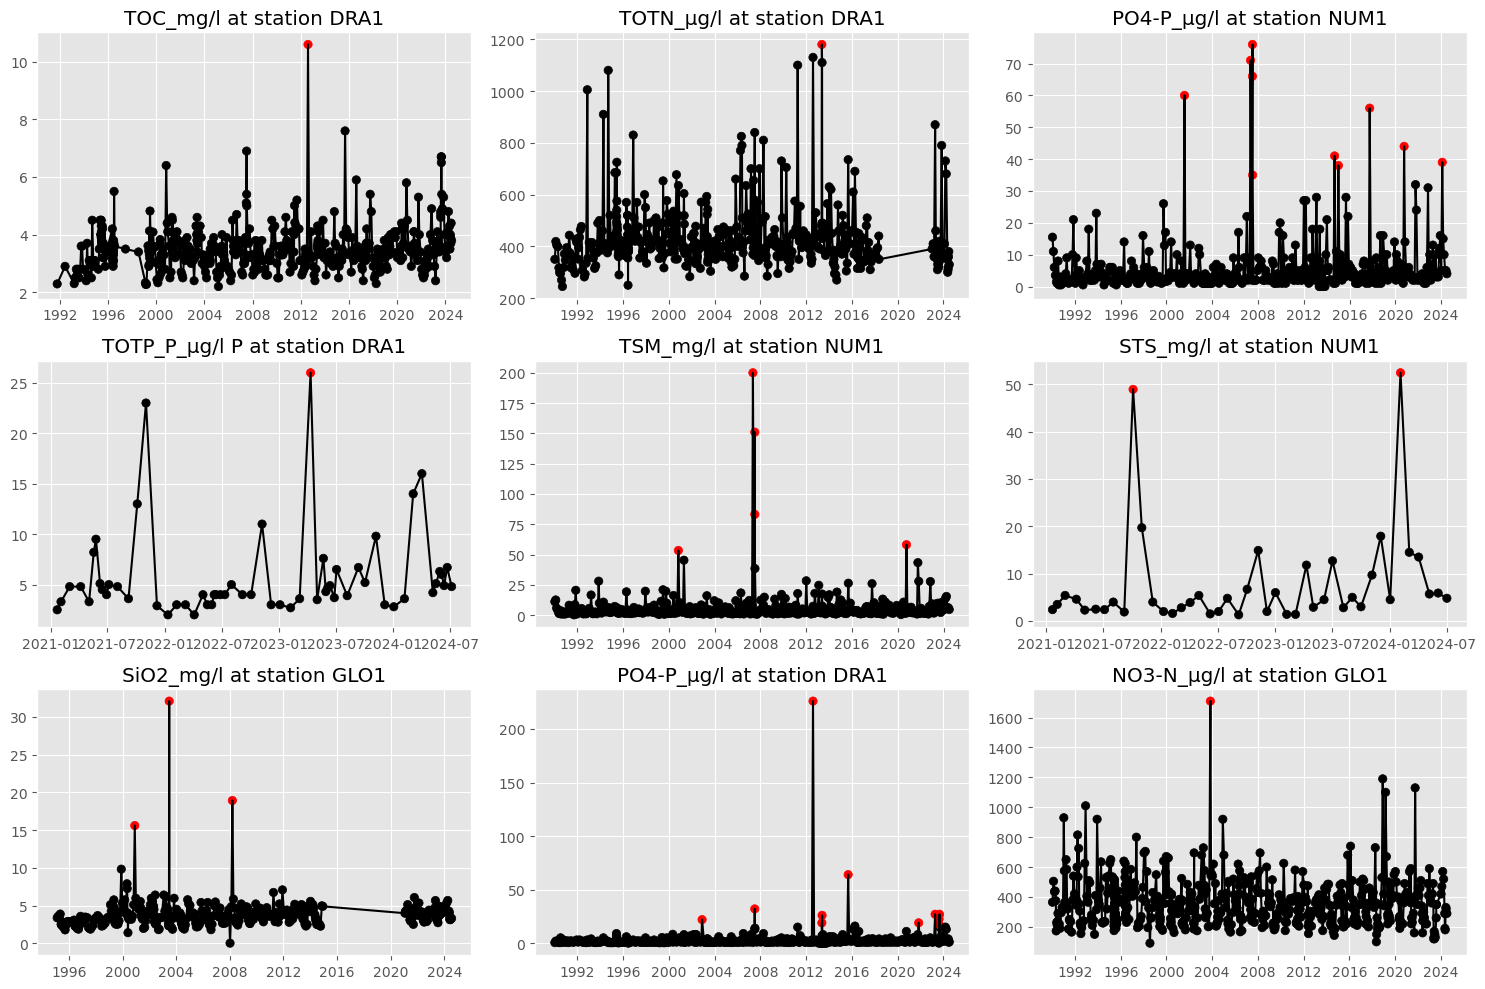

In [23]:
# Randomly sample series with outliers to check the filtering is reasonable
rand_df = (
    df.query("outlier == True")[["station_id", "station_code", "parameter"]]
    .drop_duplicates()
    .sample(n=9)
    .reset_index(drop=True)
    .copy()
)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for idx, row in rand_df.iterrows():
    stn_id = row["station_id"]
    stn_code = row["station_code"]
    par = row["parameter"]
    data_df = df.query("(station_id == @stn_id) and (parameter == @par)").copy()
    data_df.sort_values("sample_date", inplace=True)
    data_df["outlier_col"] = ["r" if i else "k" for i in data_df["outlier"]]
    axes[idx].plot(data_df["sample_date"], data_df["value"], "k-")
    axes[idx].scatter(
        data_df["sample_date"], data_df["value"], c=data_df["outlier_col"].tolist()
    )
    axes[idx].set_title(f"{par} at station {stn_code}")
plt.tight_layout()

In [24]:
# Change the format and save as csv 
df['parameter_outlier'] = 'outlier_' + df['parameter']
pivot_df = df.pivot(index=['station_id', 'station_code', 'station_name', 'sample_date'], columns='parameter', values='value').reset_index()
pivot_outlier_df = df.pivot(index=['station_id', 'station_code', 'station_name', 'sample_date'], columns='parameter_outlier', values='outlier').reset_index()

# Merge the two pivot tables
final_df = pd.merge(pivot_df, pivot_outlier_df, on=['station_id', 'station_code', 'station_name', 'sample_date'])

# Reorder columns to place outliers next to their respective variables
cols = []
for col in pivot_df.columns:
    if col not in ['station_id', 'station_code', 'station_name', 'sample_date']:
        cols.append(col)
        cols.append(f'outlier_{col}')
final_df = final_df[['station_id', 'station_code', 'station_name', 'sample_date'] + cols]

final_df.head()

,station_id,station_code,station_name,sample_date,DOC_mg/L C,outlier_DOC_mg/L C,Farge_mg Pt/l,outlier_Farge_mg Pt/l,NH4-N_µg/l,outlier_NH4-N_µg/l,...,TOTN_µg/l,outlier_TOTN_µg/l,TOTP/F_µg/l P,outlier_TOTP/F_µg/l P,TOTP_P_µg/l P,outlier_TOTP_P_µg/l P,TSM_mg/l,outlier_TSM_mg/l,UV-Abs. 410nm_Abs/cm,outlier_UV-Abs. 410nm_Abs/cm
0,40352,DRA1,Drammenselva v/Krokstadelva,1990-01-11,NaN,NaN,NaN,NaN,NaN,NaN,...,350.0,False,NaN,NaN,NaN,NaN,0.8,False,NaN,NaN
1,40352,DRA1,Drammenselva v/Krokstadelva,1990-02-12,NaN,NaN,NaN,NaN,NaN,NaN,...,419.0,False,NaN,NaN,NaN,NaN,2.0,False,NaN,NaN
2,40352,DRA1,Drammenselva v/Krokstadelva,1990-03-13,NaN,NaN,NaN,NaN,NaN,NaN,...,405.0,False,NaN,NaN,NaN,NaN,1.4,False,NaN,NaN
3,40352,DRA1,Drammenselva v/Krokstadelva,1990-04-18,NaN,NaN,NaN,NaN,NaN,NaN,...,399.0,False,NaN,NaN,NaN,NaN,1.3,False,NaN,NaN
4,40352,DRA1,Drammenselva v/Krokstadelva,1990-05-21,NaN,NaN,NaN,NaN,NaN,NaN,...,317.0,False,NaN,NaN,NaN,NaN,1.7,False,NaN,NaN


In [25]:
# Save
final_df.to_csv('../../data/river/water_chem/cleaned_niva/dremmen_glomma_numed_wc_flagged_2024.csv', index=False)